**Imports**

In [1]:
# Packages
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchsummary import summary

# Local files
import data
import encoder
import decoder
import autoencoder
import training

# Random Seed
torch.manual_seed(0)

**Load Data**

In [2]:
train_ds, val_ds, test_ds = data.get_datasets()

Files already downloaded and verified
Files already downloaded and verified


ValueError: Sum of input lengths does not equal the length of the input dataset!

In [5]:
batch_size = 64

train_dl = data.dataset_to_dataloader(train_ds, batch_size)
val_dl = data.dataset_to_dataloader(val_ds, batch_size)
test_dl = data.dataset_to_dataloader(test_ds, batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


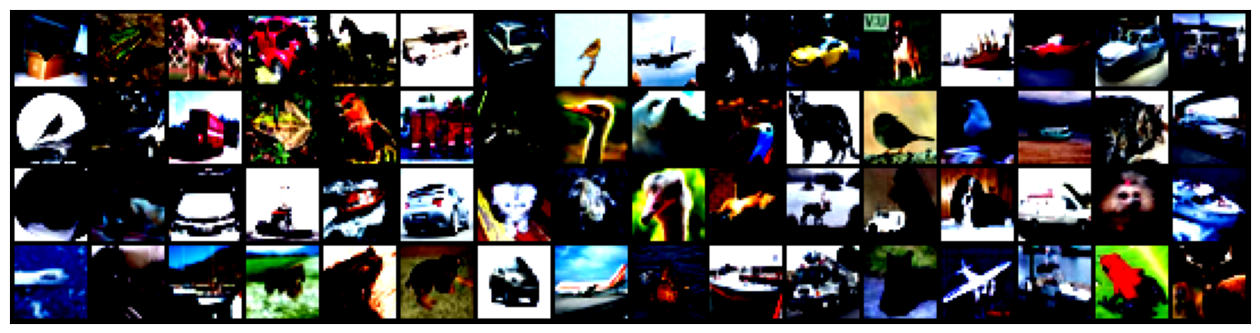

In [6]:
data.test_dataloader(train_dl)

**Create Encoders**

In [7]:
resnet_pt = encoder.resnet18(pretrained=True)
resnet_ut = encoder.resnet18(pretrained=False)

In [8]:
for param in resnet_pt.parameters():
    param.requires_grad = False

resnet_pt.avgpool = nn.AdaptiveAvgPool2d((1, 1))
resnet_pt.fc = nn.Linear(in_features=512, out_features=16, bias=True)


In [9]:
resnet_ut.avgpool = nn.AdaptiveAvgPool2d((1, 1))
resnet_ut.fc = nn.Linear(in_features=512, out_features=16, bias=True)

In [10]:
"""
if torch.cuda.is_available():
  resnet_pt.to(torch.device('cuda:0'))
  resnet_ut.to(torch.device('cuda:0'))
"""

"\nif torch.cuda.is_available():\n  resnet_pt.to(torch.device('cuda:0'))\n  resnet_ut.to(torch.device('cuda:0'))\n"

In [11]:
"""
print("Classification task accuracy")
pt_acc = str(encoder._classification_eval(resnet_pt, val_dl))
ut_acc = str(encoder._classification_eval(resnet_ut, val_dl))
print("Pretrained model accuracy:", pt_acc)
print("Untrained model accuracy:", ut_acc)
"""

'\nprint("Classification task accuracy")\npt_acc = str(encoder._classification_eval(resnet_pt, val_dl))\nut_acc = str(encoder._classification_eval(resnet_ut, val_dl))\nprint("Pretrained model accuracy:", pt_acc)\nprint("Untrained model accuracy:", ut_acc)\n'

In [12]:
control_decoder = decoder.ResNet18Dec(z_dim=16)
experiment_decoder = decoder.ResNet18Dec(z_dim=16)

In [13]:
Control_AE = autoencoder.AutoEncoder(resnet_ut, control_decoder)
Expirement_AE = autoencoder.AutoEncoder(resnet_pt, experiment_decoder)

In [14]:
if torch.cuda.is_available():
  Control_AE.to(torch.device('cuda:0'))
  Expirement_AE.to(torch.device('cuda:0'))


In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(Control_AE.parameters())

Control_AE, Control_hist = training.train(Control_AE,
            criterion,
            optimizer,
            train_dl,
            val_dl,
            save_file_name='Control_AE.pt',
            max_epochs_stop = 40,
            n_epochs = 2,
            print_every = 1)


Model has been trained for: 0 epochs.

Epoch: 0	100.00% complete. 106.16 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 0.3946 	Validation Loss: 0.3475
Epoch: 1	100.00% complete. 110.67 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.2990 	Validation Loss: 0.3345

Best epoch: 1 with loss: 0.33
232.32 total seconds elapsed. 232.32 seconds per epoch.


In [17]:
Control_AE

AutoEncoder(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


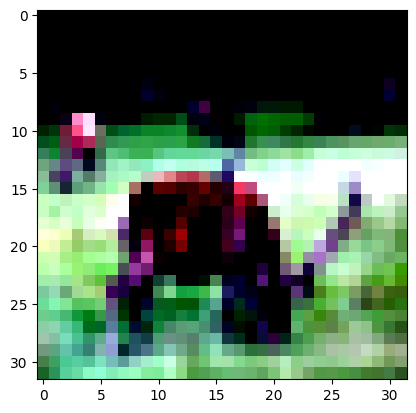

In [18]:
test_img = test_dl.dataset[0][0]
plt.imshow(test_img.permute(1,2,0))

In [19]:

test_img = torch.reshape(test_img,(1,3,32,32)).cuda()
output_img = Control_AE(test_img)
output_img = torch.reshape(output_img,(3,32,32))
output_img = output_img.cpu().detach()
output_img = output_img.numpy()
output_img = np.transpose(output_img, (1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


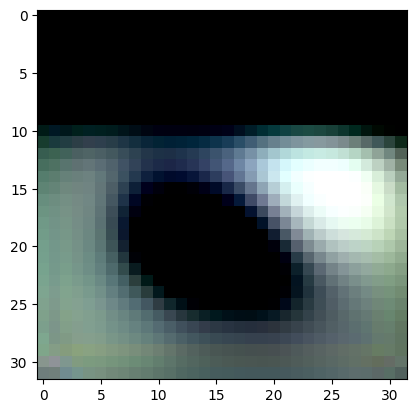

In [20]:
plt.imshow(output_img)